In [79]:
import sys
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, make_scorer, accuracy_score 
from imblearn.over_sampling import RandomOverSampler
from sklearn import model_selection
from sklearn.svm import SVC

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


sys.path.insert(0, 'D:\Fall23 Coursework\ELEC478\Competition\elecfinal')

In [2]:
from ml_pipeline import train_n_predict, validation, clean_split

In [3]:
from Data.data_cleaner import cleaner

In [6]:
## Clean data


train_path = "../Data/train_data.csv"
feature_path = "../Data/feature_weights.csv"
morph_path = "../Data/imputed_morph_embed.csv"
X_train, X_val, X_query, y_train, y_val, y_query = clean_split(train_path, feature_path, morph_path)

In [8]:
valid_X = X_val.select_dtypes(include='number').drop(["ID","pre_nucleus_id", "post_nucleus_id"], axis = 1)
valid_y = y_val

In [9]:
valid_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46156 entries, 52194 to 185831
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   adp_dist                        46156 non-null  float64
 1   post_skeletal_distance_to_soma  46156 non-null  float64
 2   pre_skeletal_distance_to_soma   46156 non-null  float64
 3   pre_oracle                      46156 non-null  float64
 4   pre_test_score                  46156 non-null  float64
 5   post_oracle                     46156 non-null  float64
 6   post_test_score                 46156 non-null  float64
 7   me_similarity                   46156 non-null  float64
 8   fw_similarity                   46156 non-null  float64
 9   nuclei_adp_dist                 46156 non-null  float64
dtypes: float64(10)
memory usage: 3.9 MB


Using Validation

In [9]:
"""
    Function that outputs a model with optimal hyperparameters
    based on a validation set using grid search

    Inputs:
    model: provided model
    param_grid: dictionary of parameters and values to validate on
    e.g. 
    {'C': [0.001,0.01,0.1,1,10], 
    'gamma':[0.1,1,10,100], 
    'kernel':('linear', 'rbf')}
    valid_X: validation X of data (pandas df)
    valid_y: validation y of data

    Outputs: 
    clf: provided model with optimum hyperparameters
    """
pre_valid_models = [RandomForestClassifier(), LinearDiscriminantAnalysis()]
param_grids = [
    {
    'max_features' : ['sqrt', 'log2'],
    'n_jobs' : [-1],
    'random_state': [1]
    },
    {
    'solver' : ['lsqr', 'eigen'],
    'shrinkage' : ['auto']
    }]
post_valid_models = []

for i in range(len(pre_valid_models)):
    best_clf = validation(model = pre_valid_models[i], 
                                        param_grid = param_grids[i], 
                                        valid_X = valid_X, 
                                        valid_y = valid_y)
    post_valid_models.append(best_clf)


(Alternative validation) USING ALL SVDs

In [60]:
pre_valid_models = [SVC()]
param_grids = [
    {
    'kernel':['rbf'],
    'C': [0.1, 1],
    }]
post_valid_models = []

for i in range(len(pre_valid_models)):
    best_clf = validation(model = pre_valid_models[i], 
                                        param_grid = param_grids[i], 
                                        valid_X = valid_X, 
                                        valid_y = valid_y)
    post_valid_models.append(best_clf)

Training and Predicting

In [12]:
query_X = X_query.select_dtypes(include='number').drop(["ID", "pre_nucleus_id", "post_nucleus_id"], axis = 1)
query_y = y_query

train_X = X_train.select_dtypes(include='number').drop(["ID", "pre_nucleus_id", "post_nucleus_id"], axis = 1)
train_y = y_train

In [36]:
"""
    Function that takes in a dataframe of data and outputs 
    a fitted "optimal" model

    Inputs:
    - train: training set
    - query: query set
    - models: dictionary of (model_name : model function) to train and predict on, with optimized 
    parameters already.

    Outputs:
    - best_clf: The optimum classifier function fitted over training data

    - accuracy_score: list of accuracies based on order of models
    passed.
    """
##Change this according to the models you passed for validation
models = {"RFC": post_valid_models[0], "LDA": post_valid_models[1]}
accuracy_score, best_clf, trained_models = train_n_predict(train_X, train_y, query_X, query_y, models)

In [37]:
print("The accuracies are", accuracy_score)

The accuracies are {'RFC': 1.0, 'LDA': 0.75692203159504}


### Ignore this section, this is purely for tuning/fidgeting w random forest 

In [13]:
model = RandomForestClassifier()

ros = RandomOverSampler(random_state=0, sampling_strategy = 'auto')
train_X_resampled, train_y_resampled = ros.fit_resample(
        train_X, train_y
    )

In [54]:
X_query_resampled, y_query_resampled = ros.fit_resample(
    query_X, query_y
)

In [55]:
model.fit(train_X_resampled,train_y_resampled)

RandomForestClassifier()

In [69]:
class_prob = model.predict_proba(X_query_resampled)

In [138]:
print(~(class_prob[:,0] > 0.85))

[False False False ... False False False]


: 

In [115]:
score = []
thresholds = np.linspace(0.5,0.999)
for threshold in thresholds:
    prediction = class_prob[:,0] > threshold
    acc = balanced_accuracy_score(y_query_resampled, ~prediction)
    score.append(acc)

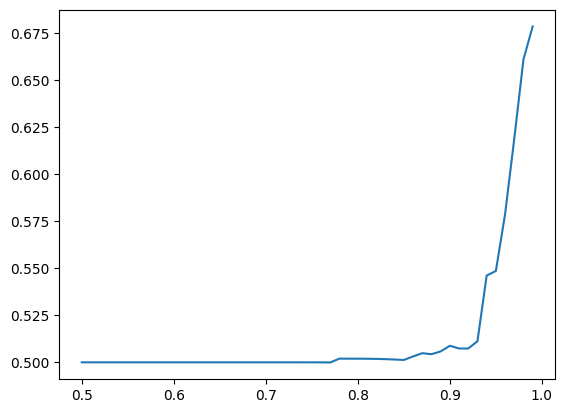

In [116]:
score = np.array(score)
plt.plot(thresholds, score)
plt.show()

In [28]:
X_query_resampled["pred"] = class_prob[:,1] > 0.5

In [62]:
hist, bin_edges = np.histogram(class_prob[:,0])

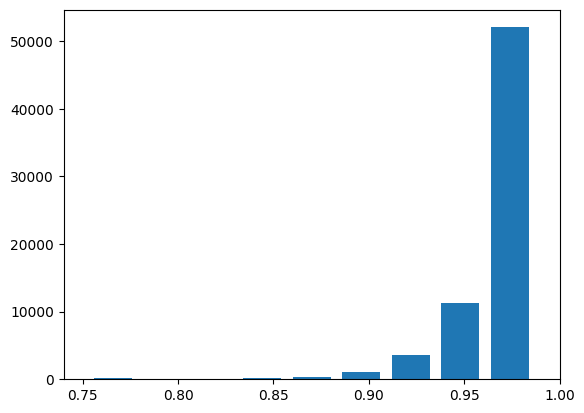

In [63]:
plt.bar(bin_edges[:-1], hist, width = 0.02)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()  

In [21]:
model.score(X_query_resampled,y_query_resampled)

0.5

Creating Submission

In [117]:
leaderboard_path = "../Data/leaderboard_data.csv"
sub_data = cleaner(leaderboard_path, feature_path, morph_path, submission = True)

In [133]:
#create a boolean prediction solution
lb_data = sub_data.select_dtypes(include='number').drop(["pre_nucleus_id", "post_nucleus_id"], axis = 1)
lb_data["connected"] = model.predict_proba(lb_data.drop("ID", axis = 1))[:,0] > 0.99

In [134]:
submission_data = lb_data.filter(['ID','connected'])

In [135]:
submission_data.to_csv('submission_data.csv',index=False)